In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings

'''
My Own Algorithms Import
'''
from preprocessing.scaler import MinMaxScaler, StandardScaler
from preprocessing.pca import PCA
from analysis.measure import ConfusionMatrix, ROC

#Ignore Warnings
warnings.filterwarnings("ignore")

#read data
housing_data = pd.read_csv('data-sets/housing.csv')

#randomize data with given seed
housing_data = housing_data.reindex(np.random.RandomState(seed=42).permutation(housing_data.index))

# Analyze the Data

In [2]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20640 entries, 20046 to 15795
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [3]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


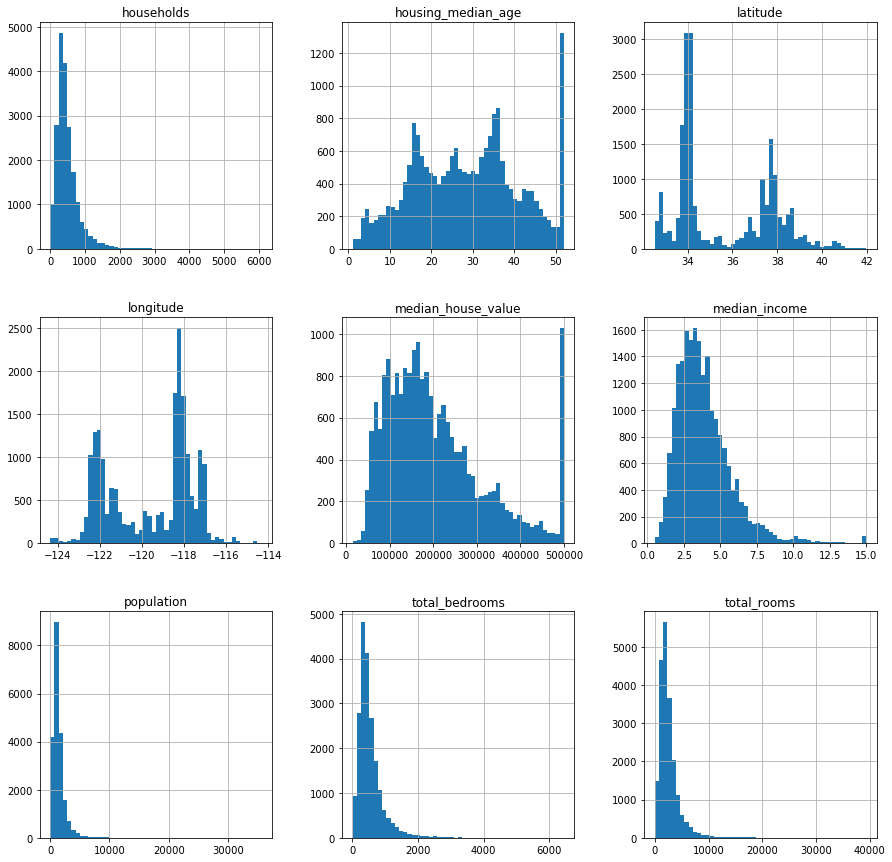

In [4]:
housing_data.hist(bins=50, figsize=(15,15))
plt.show()

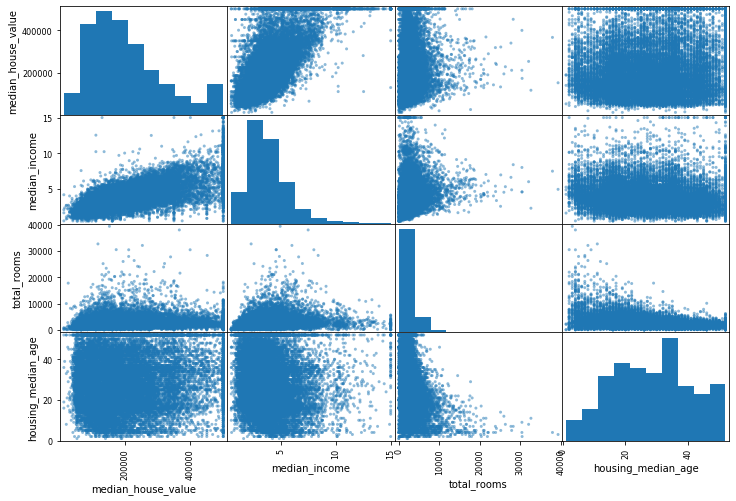

In [5]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing_data[attributes], figsize=(12, 8))

housing_data["rooms_per_household"] = housing_data["total_rooms"]/housing_data["households"]

In [6]:
corr_matrix = housing_data.corr() 
corr_matrix["median_house_value"].sort_values(ascending=False) 

median_house_value     1.000000
median_income          0.688075
rooms_per_household    0.151948
total_rooms            0.134153
housing_median_age     0.105623
households             0.065843
total_bedrooms         0.049686
population            -0.024650
longitude             -0.045967
latitude              -0.144160
Name: median_house_value, dtype: float64

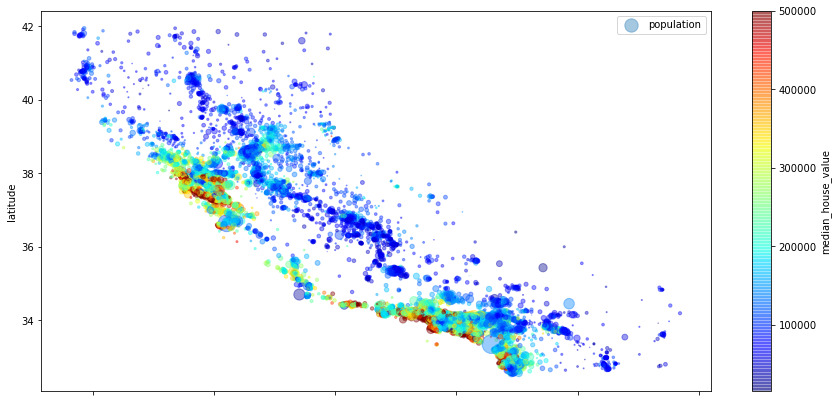

In [7]:
housing_data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing_data["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(15,7))
plt.legend()

In [8]:
housing_data = housing_data.drop(['ocean_proximity', 'households', 'total_bedrooms', 'population'], axis=1)

## Set up Data

In [9]:
seventy_five_percentile = int(len(housing_data)*0.75)
x_train, y_train = housing_data.drop(['median_house_value'], axis=1)[:seventy_five_percentile], housing_data['median_house_value'][:seventy_five_percentile]
x_test, y_test = housing_data.drop(['median_house_value'], axis=1)[seventy_five_percentile:], housing_data['median_house_value'][seventy_five_percentile:]
x_train_coordinates, x_test_coordinates = x_train[['latitude', 'longitude']], x_test[['latitude', 'longitude']]
x_train = x_train.drop(['latitude', 'longitude'], axis=1)
x_test = x_test.drop(['latitude', 'longitude'], axis=1)

# Feature Scaling

In [10]:
x_train.head()

,housing_median_age,total_rooms,median_income,rooms_per_household
20046,25.0,1505.0,1.6812,4.192201
3024,30.0,2943.0,2.5313,5.039384
15663,52.0,3830.0,3.4801,3.977155
20484,17.0,3051.0,5.7376,6.163636
9814,34.0,2351.0,3.7250,5.492991


In [11]:
standard_scaler = StandardScaler()
x_train_standard_scaled = standard_scaler.fit_transform(x_train)
x_train_standard_scaled.head()

,housing_median_age,total_rooms,median_income,rooms_per_household
20046,-0.290806,-0.513620,-1.155641,-0.538499
3024,0.105825,0.146215,-0.706809,-0.164886
15663,1.851000,0.553220,-0.205867,-0.633336
20484,-0.925415,0.195771,0.986036,0.330917
9814,0.423129,-0.125428,-0.076566,0.035158


# Principal Component Analysis

# PCA 3D

In [12]:
pca = PCA(3)
pca_data_3d = pca.fit_transform(x_train_standard_scaled)
pca_data_3d

,Principal Component 1,Principal Component 2,Principal Component 3
0,0.972672,0.763988,0.664000
1,0.413392,0.444762,0.122795
2,1.030404,-0.325497,-1.416330
3,-1.209176,-0.066679,0.056764
4,0.290327,-0.265452,-0.086463
...,...,...,...
15475,1.880487,-0.414111,-0.756569
15476,-0.466788,2.033288,-0.237504
15477,0.080437,0.341624,0.268840
15478,1.822537,-0.465405,-0.663939


## Scale and Transform Test Dimensions

In [13]:
x_test_scaled = standard_scaler.transform(x_test)
pca_3d_test_data = pca.transform(x_test_scaled)

# K Means Clustering

In [16]:
import math

class KMC:
    def __init__(self, k):
        self.k = k
        
    def initialize_centroids(self, train_data):
        if (self.k > len(train_data)):
            print("k cannot be greater than size of data")
            return
        centroids = train_data.sample(self.k).to_numpy()
        return centroids
        
    def calculate_centroids(self, train_data, current_centroids, cluster_belongings):
        train_data['cluster'] = cluster_belongings
        new_centroids = []
        for i in range(self.k):
            cluster_k_data = train_data[train_data['cluster']==i]
            cluster_k_data = cluster_k_data.drop(['cluster'], axis=1)
            new_centroid = []
            for column in cluster_k_data.columns:
                new_centroid.append(np.mean(cluster_k_data[column]))
            print(new_centroid)
            new_centroids.append(new_centroid)
        return new_centroids
    
    def euclidean_distance(self, point1, point2):
        distance = 0
        for i in range(len(point1)):
            distance += ((point2[i] - point1[i])**2)
        return math.sqrt(distance)
    
    def closest_cluster(self, centroids, sample):
        closest_c = 0
        shortest_distance = self.euclidean_distance(centroids[0], sample)
        for i in range(1, len(centroids)):
            centroid = centroids[i]
            dist = self.euclidean_distance(centroid, sample)
            if (dist < shortest_distance):
                closest_c = i
                shortest_distance = dist
        return closest_c
    
    def fit(self, train_data):
        centroids = self.initialize_centroids(train_data)
        cluster_belongings = [0 for i in range(len(train_data))]
        for i in range(len(train_data)):
            sample = train_data.iloc[i]
            cluster = self.closest_cluster(centroids, sample)
            cluster_belongings[i] = cluster
        self.centroids = self.calculate_centroids(train_data, centroids, cluster_belongings)
            
    def predict(self, test_data):
        data_predictions = []
        for sample in test_data:
            cluster = self.closest_cluster(self.centroids, sample)
            data_predictions.append(cluster)
        return data_predictions, self.centroids
    
kmc = KMC(2)
kmc.fit(pca_data_3d)
centroid_prediction, centroids = kmc.predict(pca_3d_test_data.values)

[-0.48335094974005427, 0.28075766695316623, 0.17625120731710567]
[0.9904077073361798, -0.5752850126676753, -0.36114660423869416]


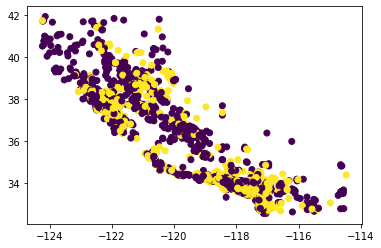

In [17]:
plt.scatter(x_test_coordinates['longitude'], x_test_coordinates['latitude'], c=centroid_prediction)